# Setup

In [125]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from typing import Dict, List, Tuple, Callable

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.utils import resample

from pathlib import Path
import warnings, re
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=re.compile(r".*'force_all_finite'.*will be removed in 1\.8.*").pattern
)

plt.rcParams["figure.dpi"] = 160
sns.set_context("notebook")

In [25]:
# Load core view
p = Path("data/processed") / "hbn_core_view_v1.csv"
df = pd.read_csv(p)

In [26]:
import os

def find_project_root(start: Path | None = None) -> Path:
    """Return the repo root by searching upward for markers."""
    p = (start or Path.cwd()).resolve()
    markers = {".git", "environment.yml", "README.md"}
    while True:
        if any((p/m).exists() for m in markers):
            return p
        if p.parent == p:
            # fallback: use start if nothing found
            return (start or Path.cwd()).resolve()
        p = p.parent

# allow manual override via env var if needed (e.g., in CI/Colab)
ROOT = Path(os.environ.get("HBN_PROJ_ROOT", find_project_root()))
DATA_DIR     = ROOT / "data"
RESULTS_DIR  = ROOT / "results" / "HDBSCAN"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("Results dir :", RESULTS_DIR)

Project root: /Users/yizj/Desktop/hbn_project
Results dir : /Users/yizj/Desktop/hbn_project/results/HDBSCAN


# Preprocess

## Choose columns (Primary: age-corrected EF + TD) + profiling cols

In [28]:
def pick(df, prefer, fallback=None, must=True):
    prefer = prefer if isinstance(prefer, (list, tuple)) else [prefer]
    for c in prefer:
        if c in df.columns:
            return c
    if fallback:
        fallback = fallback if isinstance(fallback, (list, tuple)) else [fallback]
        for c in fallback:
            if c in df.columns:
                return c
    if must:
        raise KeyError(f"Missing any of: {prefer + (fallback or [])}")
    return None

# Age-corrected EF (preferred); graceful fallbacks if needed
COL_FLANK = pick(df,
    ["NIH_final,NIH_Flanker_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_Flanker_Computed_Score"]
)
COL_LIST  = pick(df,
    ["NIH_final,NIH_List_Sort_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_List_Sort_Uncorr_Stnd","NIH_final,NIH_List_Sort_Raw"]
)
COL_PROC  = pick(df,
    ["NIH_final,NIH_Processing_Age_Corr_Stnd"],
    fallback=["NIH_final,NIH_Processing_Computed_Score"]
)

# Temporal discounting summary features
TD_COLS = ["logk_mean","k_abs_diff_log"]
for c in TD_COLS:
    if c not in df.columns:
        raise KeyError(f"Missing TD feature: {c}")

FEATURES = [COL_FLANK, COL_LIST, COL_PROC] + TD_COLS
PROFILE_ONLY = ["Age","Sex"]  # profiled later (not used to cluster)

print("Clustering features:", FEATURES)
print("Profile-only cols :", PROFILE_ONLY)

Clustering features: ['NIH_final,NIH_Flanker_Age_Corr_Stnd', 'NIH_final,NIH_List_Sort_Age_Corr_Stnd', 'NIH_final,NIH_Processing_Age_Corr_Stnd', 'logk_mean', 'k_abs_diff_log']
Profile-only cols : ['Age', 'Sex']


## Build X, check missingness, impute + scale

In [29]:
# X (for clustering) and a profiling frame
X = df[FEATURES].copy()
prof = pd.concat([X, df[PROFILE_ONLY]], axis=1)

# Normalize Sex to 0/1 for profiling %
if "Sex" in prof.columns and prof["Sex"].dtype == "O":
    prof["Sex"] = (prof["Sex"].astype(str).str.strip().str.lower()
                   .map({"male":1,"m":1,"female":0,"f":0}))

# Column-wise missingness (%)
miss_col = X.isna().mean().sort_values(ascending=False)
display(miss_col.to_frame("missing_pct"))

# How many cells will be imputed per column?
cells_to_impute = X.isna().sum().rename("n_imputed_if_median")
display(cells_to_impute.to_frame())

# Impute (median) + scale (z) for clustering
pre = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])
Xp = pre.fit_transform(X)
Xp.shape

,missing_pct
k_abs_diff_log,0.033924
"NIH_final,NIH_Flanker_Age_Corr_Stnd",0.000000
"NIH_final,NIH_List_Sort_Age_Corr_Stnd",0.000000
"NIH_final,NIH_Processing_Age_Corr_Stnd",0.000000
logk_mean,0.000000


,n_imputed_if_median
"NIH_final,NIH_Flanker_Age_Corr_Stnd",0
"NIH_final,NIH_List_Sort_Age_Corr_Stnd",0
"NIH_final,NIH_Processing_Age_Corr_Stnd",0
logk_mean,0
k_abs_diff_log,67


(1975, 5)

## Pre-clustering visuals

Understand EF–TD relations before clustering.

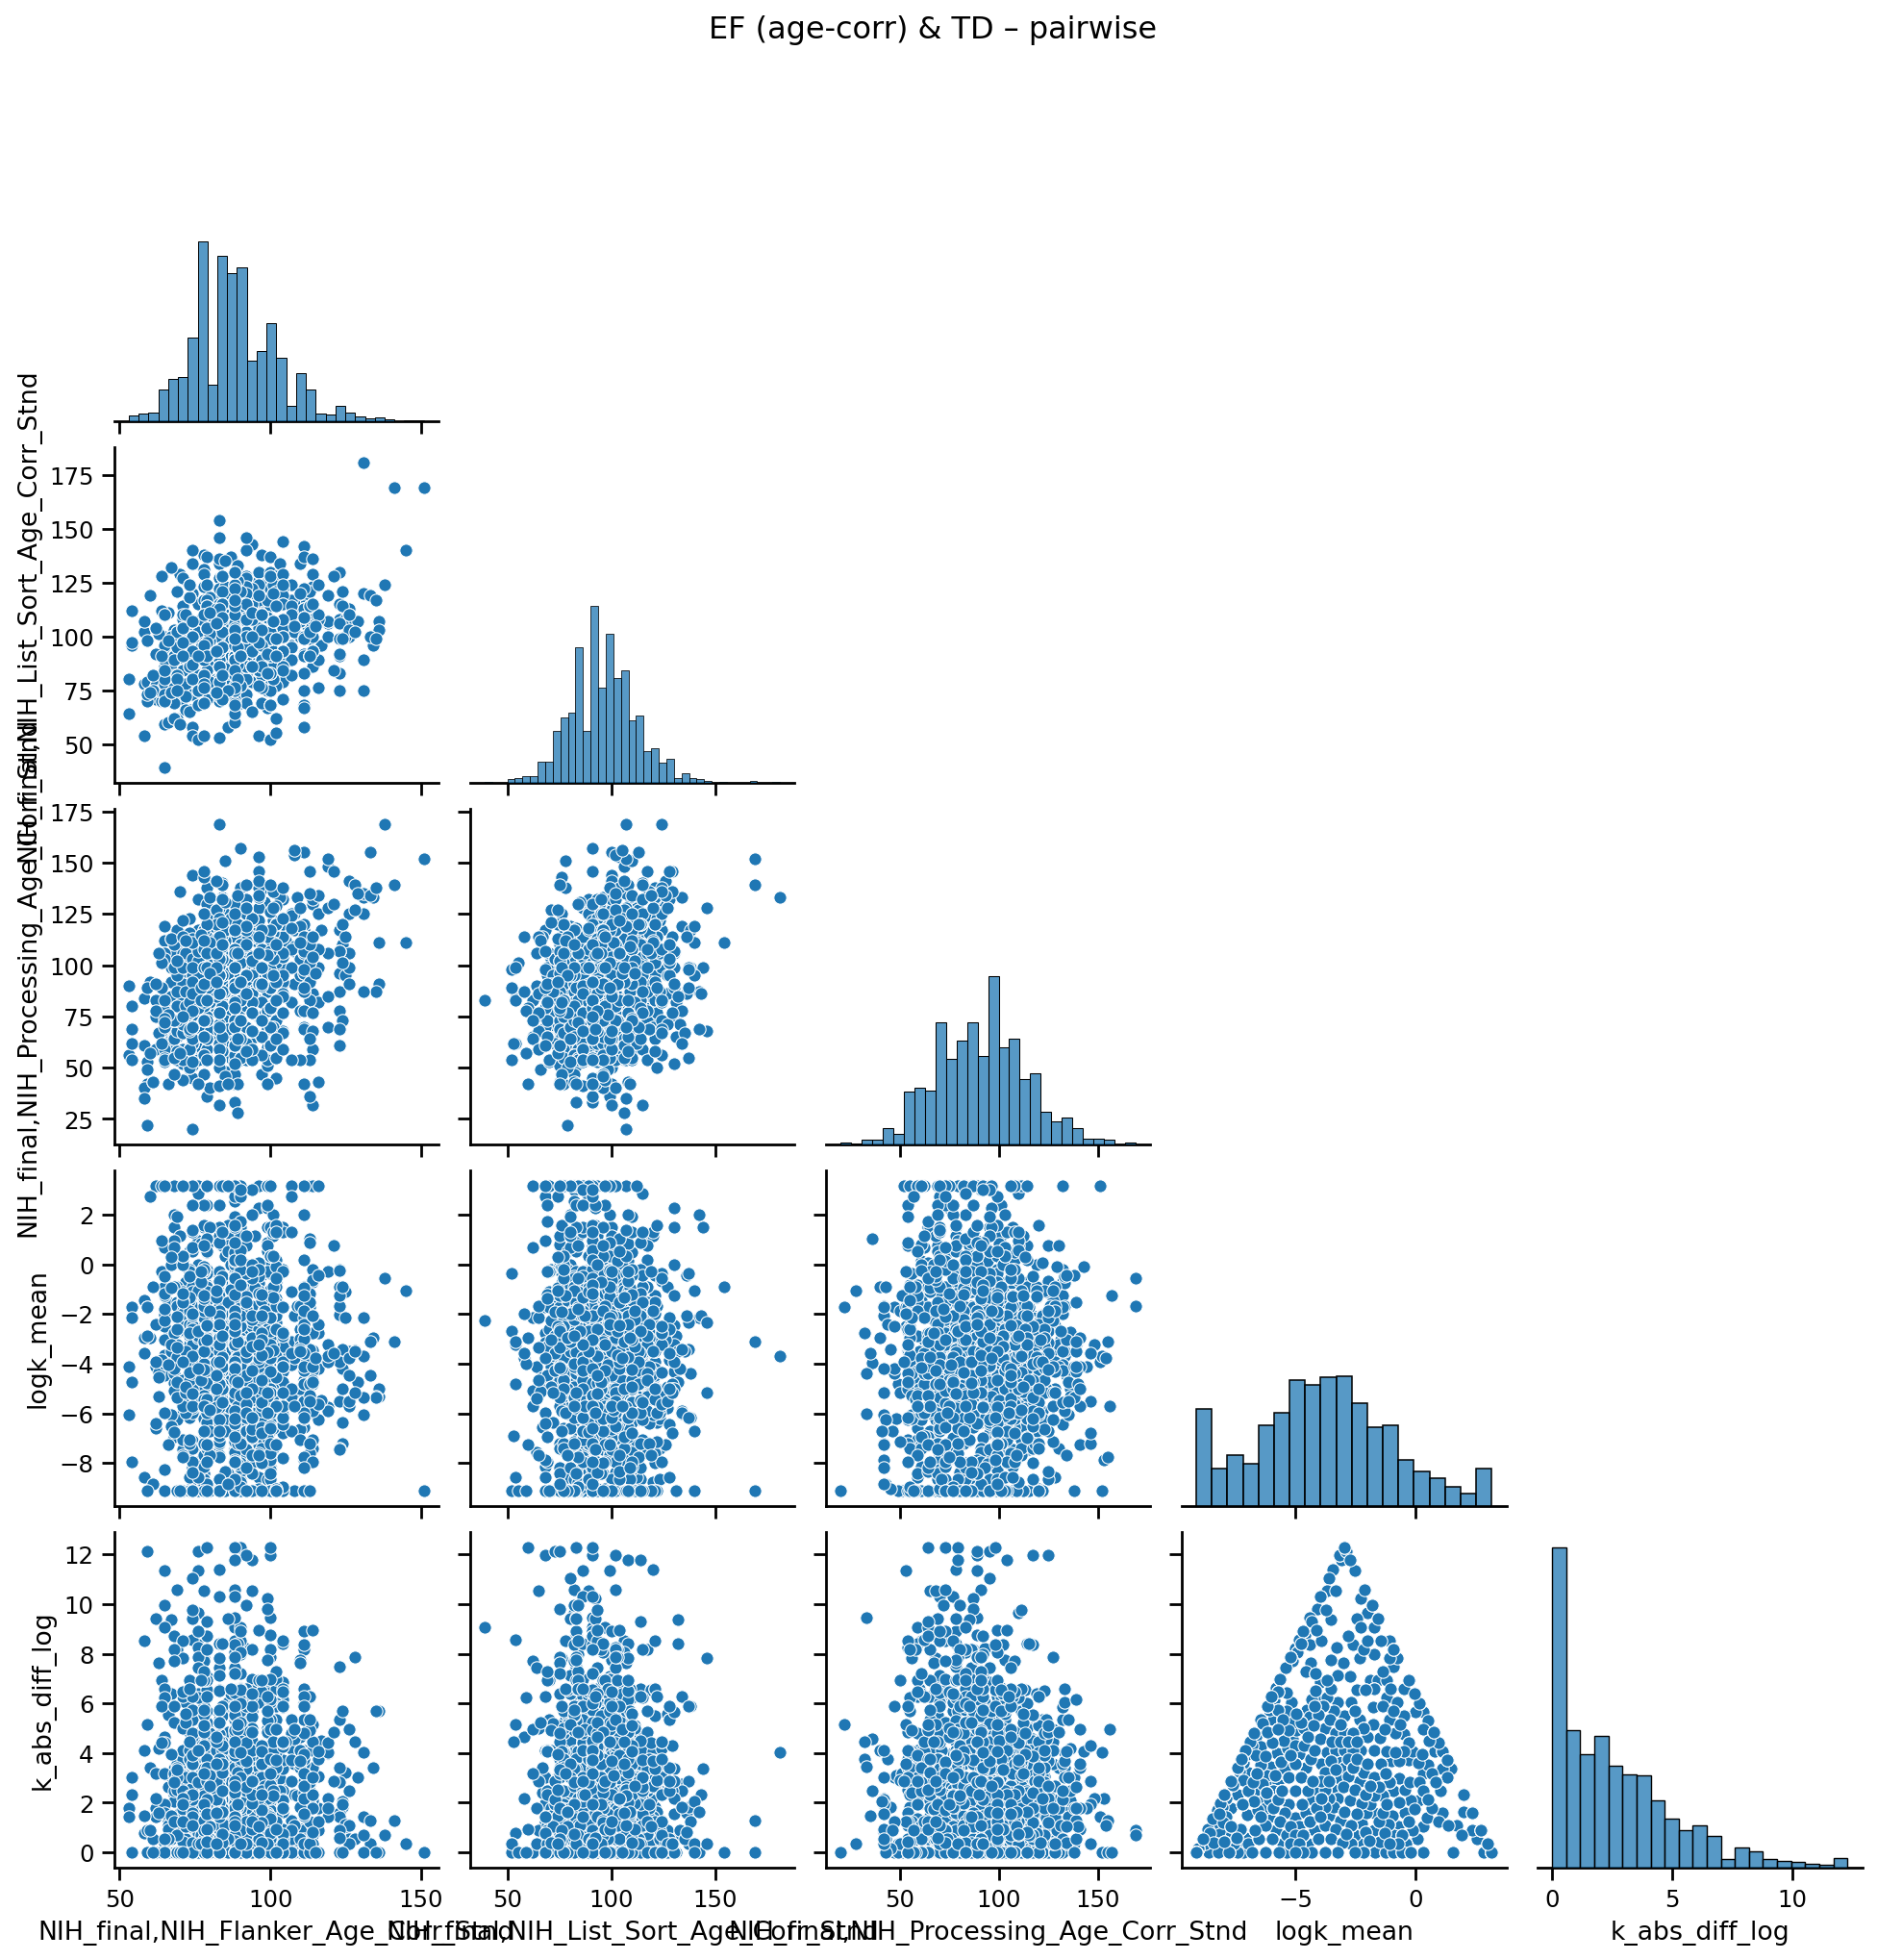

/var/folders/4_/vsf2fnhd3bz458z2nvlnyrmm0000gn/T/ipykernel_64174/4008700555.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.title("EF (age-corr) & TD – correlation"); plt.tight_layout(); plt.show()


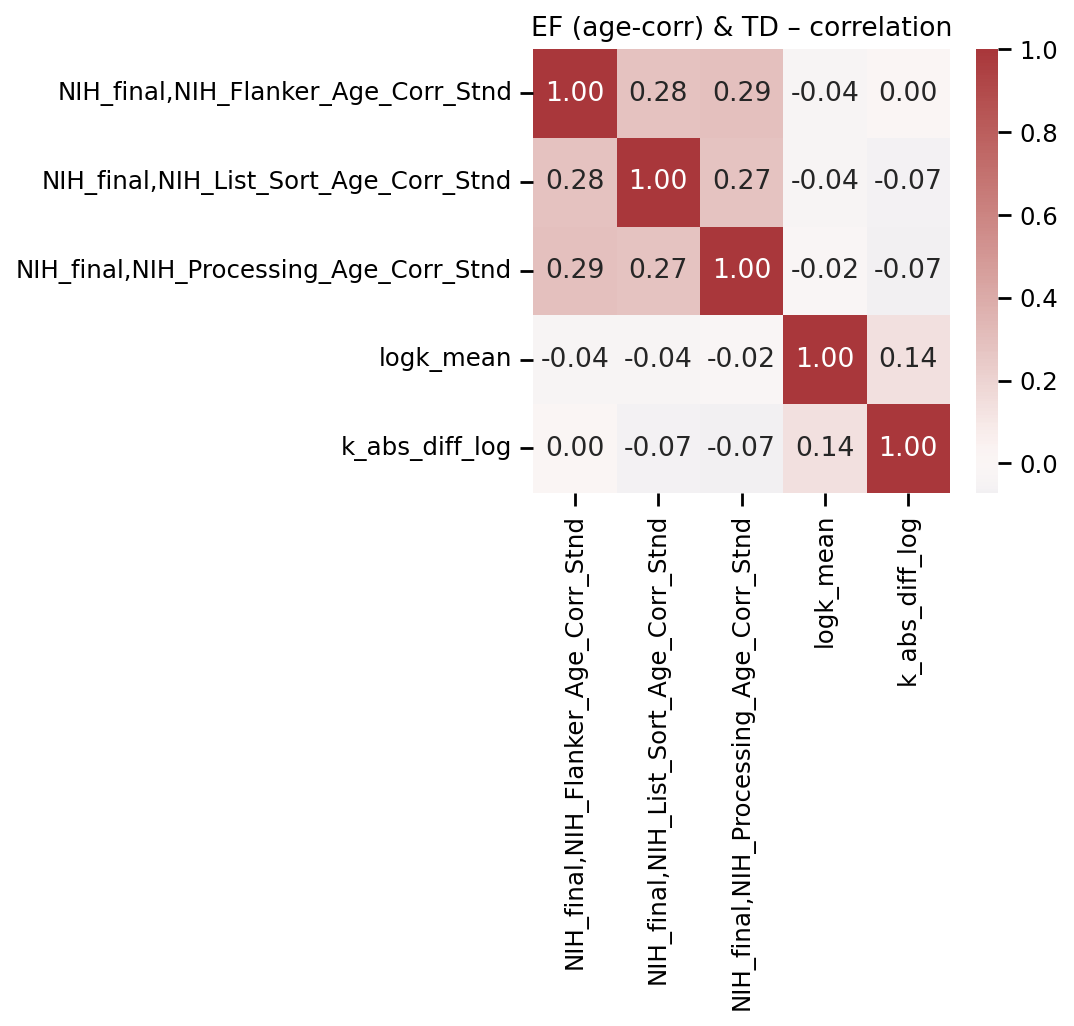

In [38]:
# Pairwise relations (sample to keep light, if large)
sub = prof[FEATURES].sample(n=min(1500, len(prof)), random_state=0)
sns.pairplot(sub, diag_kind="hist", corner=True)
plt.suptitle("EF (age-corr) & TD – pairwise", y=1.02); plt.show()

# Correlation heatmap
corr = prof[FEATURES].corr()
plt.figure(figsize=(4.2,3.6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("EF (age-corr) & TD – correlation"); plt.tight_layout(); plt.show()

# Clustering

## Helpers (silhouette + PCA scatter + profiler)

In [71]:
# Reuse your scaled data Xp; build a 2D PCA projection for the scatter plots
pca2 = PCA(n_components=2, random_state=0).fit(Xp)
Z2 = pca2.transform(Xp)  # shape (n_samples, 2)

def plot_silhouette(name, labels, X_for_sil):
    """Silhouette bar plot; skips if fewer than 2 clusters."""
    labs = np.asarray(labels)
    uniq = np.unique(labs)
    if len(uniq) < 2:
        print(f"[{name}] Cannot compute silhouette (only {len(uniq)} cluster).")
        return

    sil_vals = silhouette_samples(X_for_sil, labs)
    sil_mean = silhouette_score(X_for_sil, labs)
    print(f"[{name}] Silhouette: {sil_mean:.3f}")

    y_lower = 10
    fig, ax = plt.subplots(figsize=(6, 3.2), dpi=200)
    for c in sorted(uniq):
        m = labs == c
        sv = np.sort(sil_vals[m])
        size_i = sv.size
        y_upper = y_lower + size_i
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sv, alpha=0.6)
        ax.text(-0.05, y_lower + 0.5*size_i, f"C{c}")
        y_lower = y_upper + 8
    ax.axvline(sil_mean, color="k", linestyle="--", linewidth=1)
    ax.set_title(f"Silhouette — {name}")
    ax.set_xlabel("Silhouette value")
    ax.set_ylabel("Samples")
    fig.tight_layout()
    plt.show()

def plot_pca_scatter(name, labels, Z2):
    """2D PCA scatter using Z2 (from Xp)."""
    labs = np.asarray(labels)
    fig, ax = plt.subplots(figsize=(5.2, 3.6), dpi=220)
    for c in np.unique(labs):
        m = labs == c
        ax.scatter(Z2[m, 0], Z2[m, 1], s=10, alpha=0.85, label=f"C{c}")
    ax.legend(frameon=True, fontsize=8)
    ax.set_title(f"PCA scatter — {name}")
    ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, linewidth=0.3)
    fig.tight_layout()
    plt.show()

In [69]:
def profile_table_and_heatmap_mixed(
    df_original, labels, z_cols, age_col="Age", sex_col="Sex",
    title="Cluster profiles (Age yrs, Sex %M; EF/TD in population-z)", robust_q=0.95
):
    # Keep only labeled points (exclude noise = -1)
    dfc = df_original.copy()
    lab = np.asarray(labels)
    m = lab >= 0
    dfc = dfc.loc[m].copy()
    lab = lab[m]
    if len(np.unique(lab)) < 1:
        print("No non-noise clusters to profile.")
        return
    
    # Ensure Sex is numeric 0/1 for % display
    if sex_col in dfc.columns:
        dfc[sex_col] = pd.to_numeric(dfc[sex_col], errors="coerce")
    
    # Build population-z for z_cols (across all rows kept above)
    Zcols = dfc[z_cols]
    Z = (Zcols - Zcols.mean()) / Zcols.std(ddof=0)
    
    # Table of cluster means
    prof_age = dfc.groupby(lab)[age_col].mean().rename("Age (yrs)") if age_col in dfc else None
    prof_sex = (100 * dfc.groupby(lab)[sex_col].mean()).rename("Sex (%M)") if sex_col in dfc else None
    prof_z   = Z.groupby(lab).mean()
    
    parts = []
    if prof_age is not None: parts.append(prof_age)
    if prof_sex is not None: parts.append(prof_sex)
    parts.append(prof_z)
    prof = pd.concat(parts, axis=1).round(2)
    
    display(prof.style.set_caption(title))
    
    # Heatmap: use population-z values for EF/TD columns; Age/Sex shown but not used for color
    # Build a numeric matrix Mz aligned to prof's columns
    display_cols = prof.columns.tolist()
    # Construct a matrix in which non-z columns (Age/Sex) are anchored at 0 for color
    Mz = np.zeros_like(prof.values, dtype=float)
    for j, col in enumerate(display_cols):
        if col in ("Age (yrs)","Sex (%M)"):
            Mz[:, j] = 0.0  # no color influence
        else:
            # col exists in prof_z; already population-z means
            Mz[:, j] = prof[col].values
    
    # Robust symmetric color limits from |z|
    limit = np.nanpercentile(np.abs(Mz[:, ~np.isin(display_cols, ["Age (yrs)","Sex (%M)"])]), robust_q*100)
    vmax = max(1.0, float(limit))  # at least ±1
    norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(9.0, 3.8))
    im = ax.imshow(Mz, aspect="auto", cmap="RdBu_r", norm=norm)

    ax.set_yticks(range(Mz.shape[0])); ax.set_yticklabels([f"C{c}" for c in prof.index])
    ax.set_xticks(range(Mz.shape[1])); ax.set_xticklabels(display_cols, rotation=45, ha="right")

    # Cell text: Age as years, Sex as %, others as mean (original prof values)
    for i in range(Mz.shape[0]):
        for j, col in enumerate(display_cols):
            val = prof.iloc[i, j]
            if col == "Age (yrs)":
                txt = f"{val:.1f}"
            elif col == "Sex (%M)":
                txt = f"{val:.0f}%"
            else:
                txt = f"{val:.2f}"
            # Text color for contrast
            txt_color = "black" if abs(Mz[i, j]) < 0.6*vmax else "white"
            ax.text(j, i, txt, ha="center", va="center", color=txt_color, fontsize=8)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("EF/TD population z (Age/Sex not colored)")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()

In [76]:
def profile(name, labels, z_cols):
    """Mixed-unit profile table + heatmap (your helper)."""
    print(f"[{name}] Cluster counts:")
    print(pd.Series(labels).value_counts().rename("count"))

    profile_table_and_heatmap_mixed(
        df_original=prof,          # original units for EF/TD + Age/Sex
        labels=labels,
        z_cols=z_cols,             # EF+TD as population-z in the heatmap color
        age_col="Age",
        sex_col="Sex",
        title=f"{name} — Cluster profiles (Age yrs, Sex %M; EF/TD population-z)",
        robust_q=0.95,
    )

## HDBSCAN

[HDBSCAN] min_cluster_size=40, min_samples=13 | noise=82.8% | silhouette=0.368
[HDBSCAN (mcs=40, ms=13)] Silhouette: 0.368


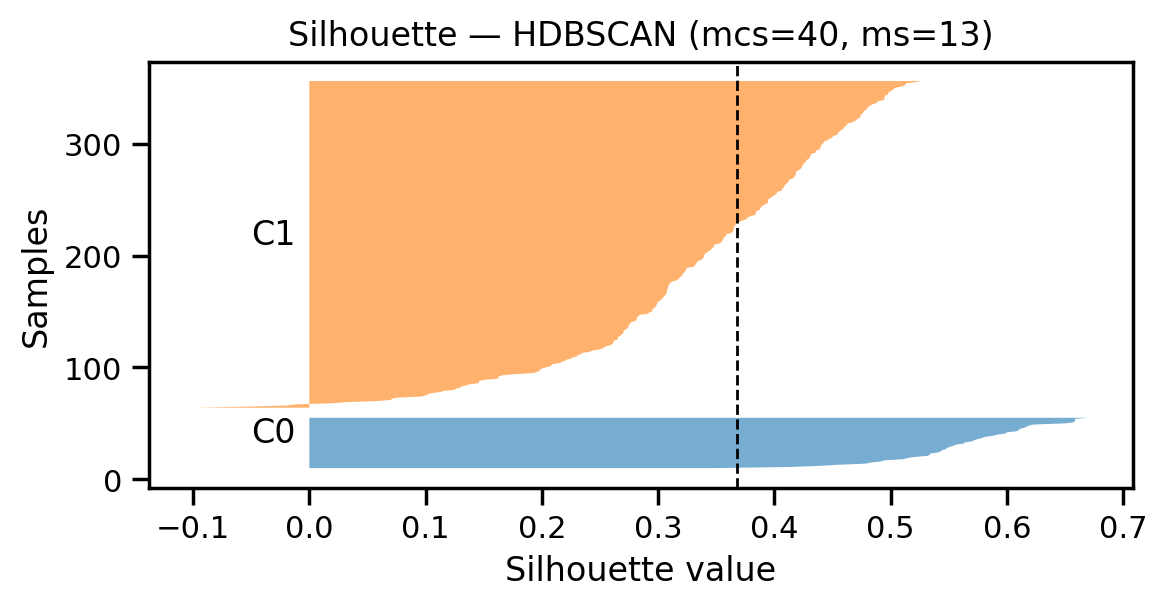

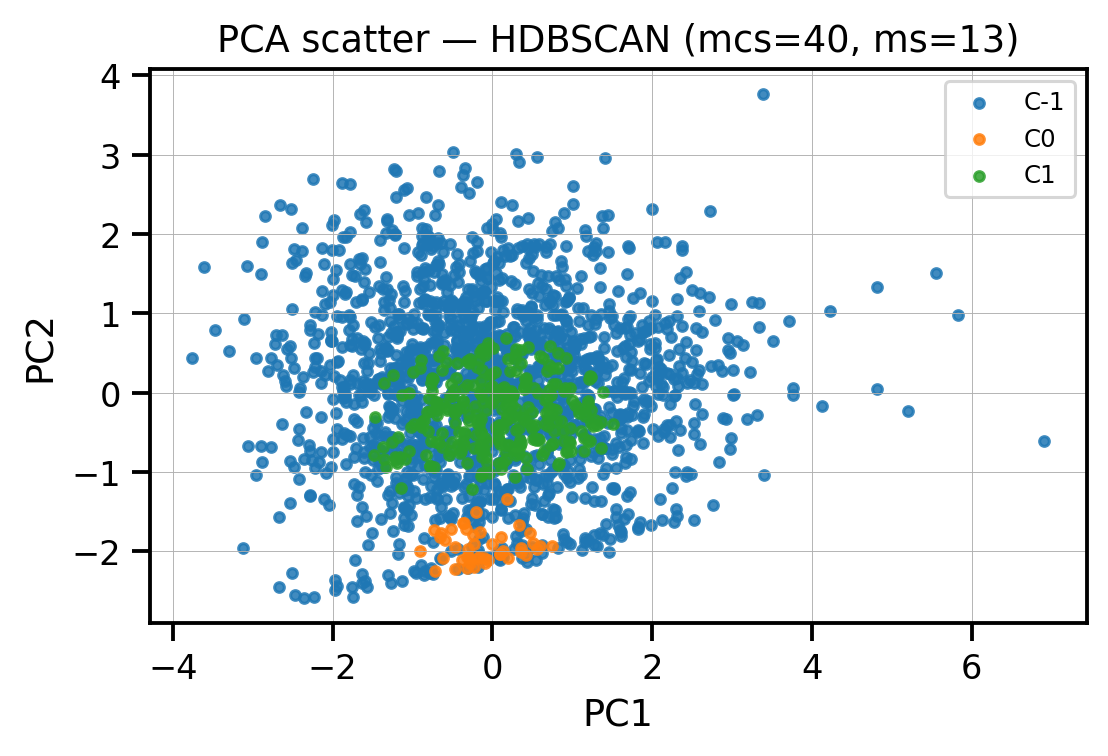

[HDBSCAN (mcs=40, ms=13)] Cluster counts:
-1    1636
 1     293
 0      46
Name: count, dtype: int64


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,9.280000,39.130000,-0.130000,-0.620000,-0.710000,-2.120000,-0.980000
1,11.030000,35.840000,0.020000,0.100000,0.110000,0.330000,0.160000


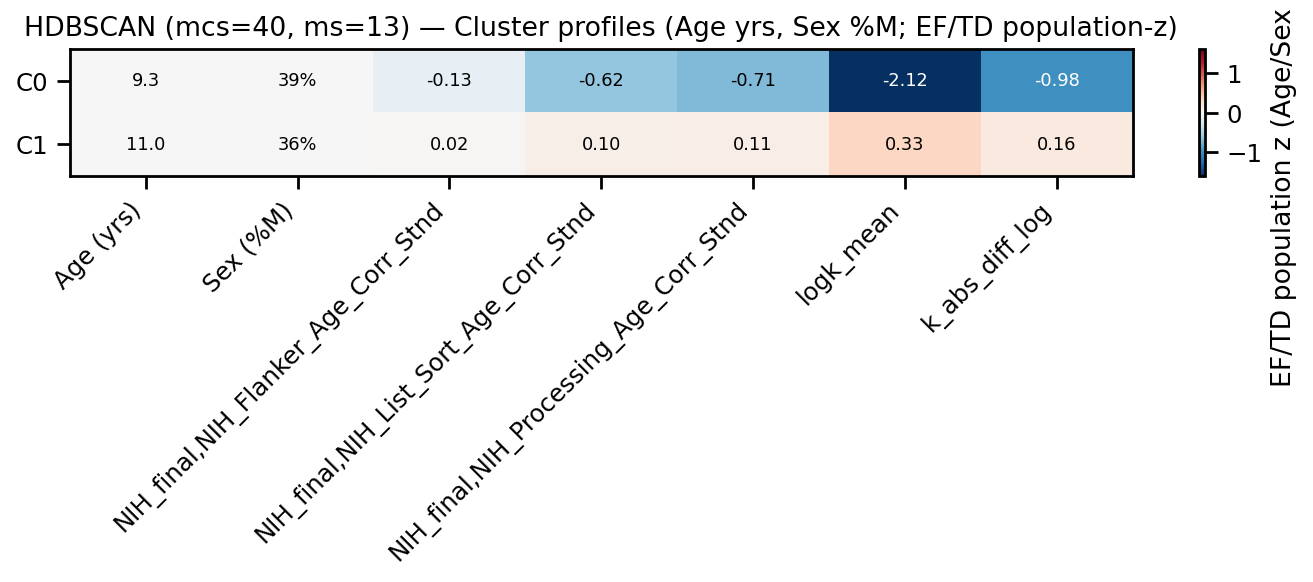

In [81]:
def hdbscan_best(X_scaled, min_cluster_sizes=(40, 60, 80, 120),
                 min_samples_factors=(1, 2, 3), metric="euclidean"):
    best = None
    for mcs in min_cluster_sizes:
        for msf in min_samples_factors:
            ms = max(1, mcs // msf)
            hdb = hdbscan.HDBSCAN(min_cluster_size=mcs,
                                  min_samples=ms,
                                  metric=metric)
            lab = hdb.fit_predict(X_scaled)
            m = lab >= 0  # exclude noise
            nclu = len(np.unique(lab[m]))
            score = silhouette_score(X_scaled[m], lab[m]) if (m.any() and nclu >= 2) else -np.inf
            cand = (score, mcs, ms, lab, hdb)
            if best is None or score > best[0]:
                best = cand
    return best  # (sil, mcs, ms, labels, model)

sil_hdb, mcs, ms, lab_hdb, hdb_model = hdbscan_best(Xp)
noise_pct = (lab_hdb == -1).mean() * 100
print(f"[HDBSCAN] min_cluster_size={mcs}, min_samples={ms} | noise={noise_pct:.1f}% | silhouette={sil_hdb:.3f}")

# Silhouette on clustered points only, PCA scatter on all (noise shown as its label)
m = lab_hdb >= 0
plot_silhouette(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb[m], Xp[m])
plot_pca_scatter(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb, Z2)

# Mixed-unit profiles (Age yrs, Sex %M; EF/TD colored by population-z)
profile(f"HDBSCAN (mcs={mcs}, ms={ms})", lab_hdb, z_cols=FEATURES)

## KMeans

[KMeans] k=4 | silhouette=0.184
[KMeans (k=4)] Silhouette: 0.184


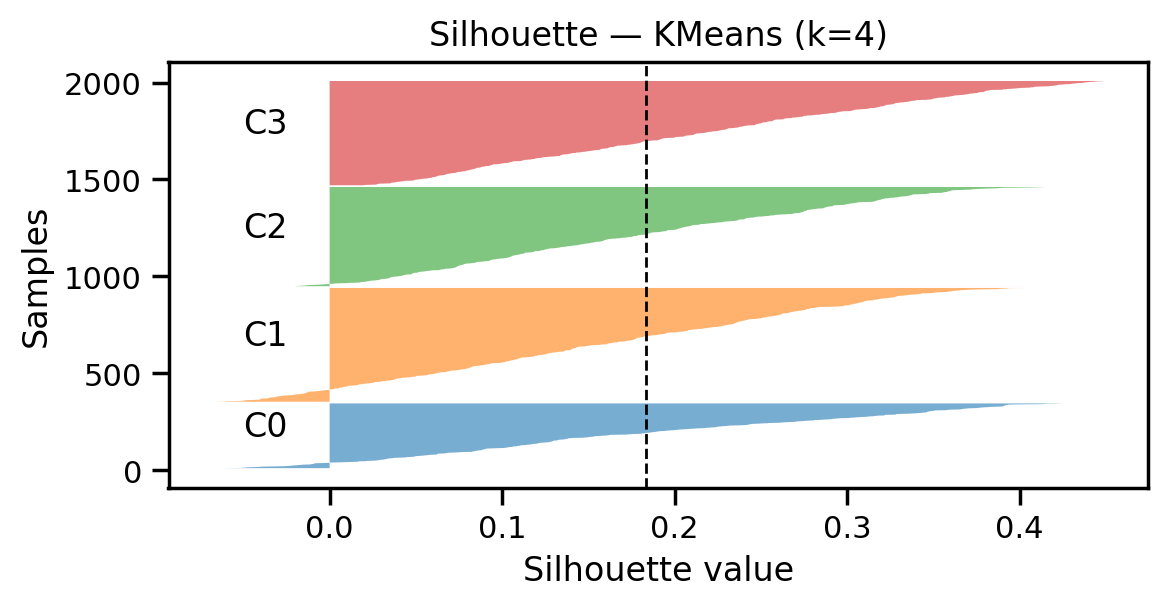

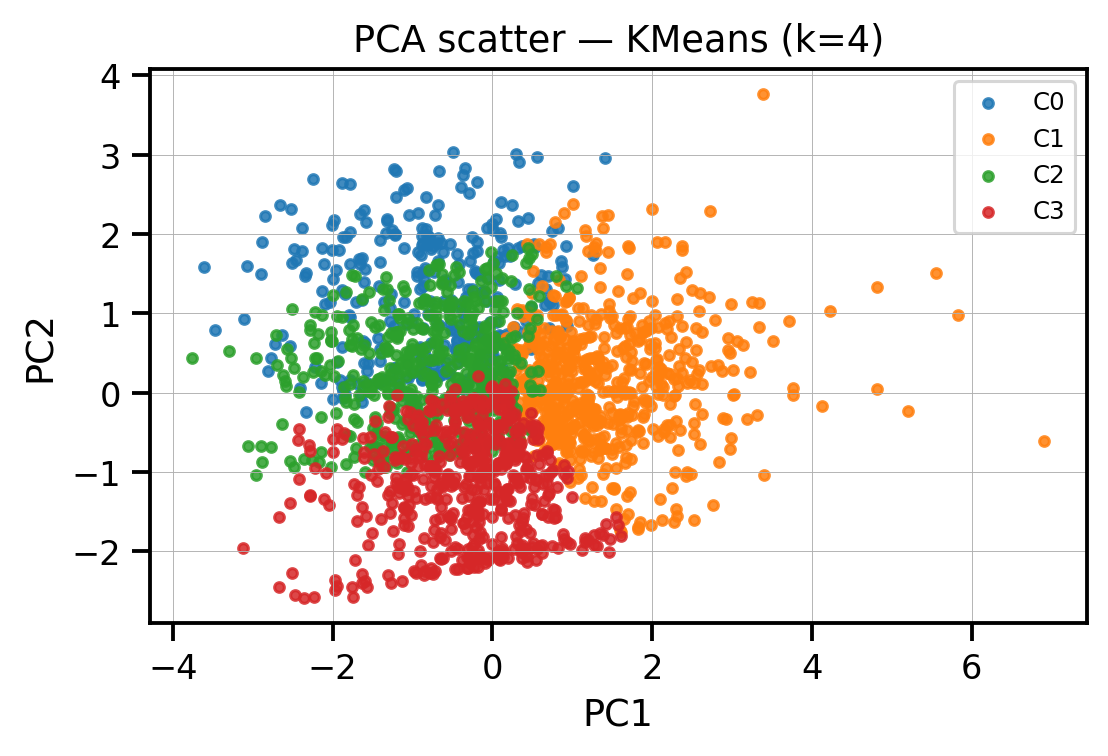

[KMeans (k=4)] Cluster counts:
1    588
3    539
2    513
0    335
Name: count, dtype: int64


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,9.750000,31.140000,-0.130000,-0.360000,-0.370000,0.120000,1.640000
1,10.970000,33.500000,0.760000,0.800000,0.890000,-0.030000,-0.170000
2,10.720000,32.360000,-0.500000,-0.400000,-0.350000,0.990000,-0.380000
3,10.110000,38.590000,-0.270000,-0.270000,-0.410000,-0.980000,-0.520000


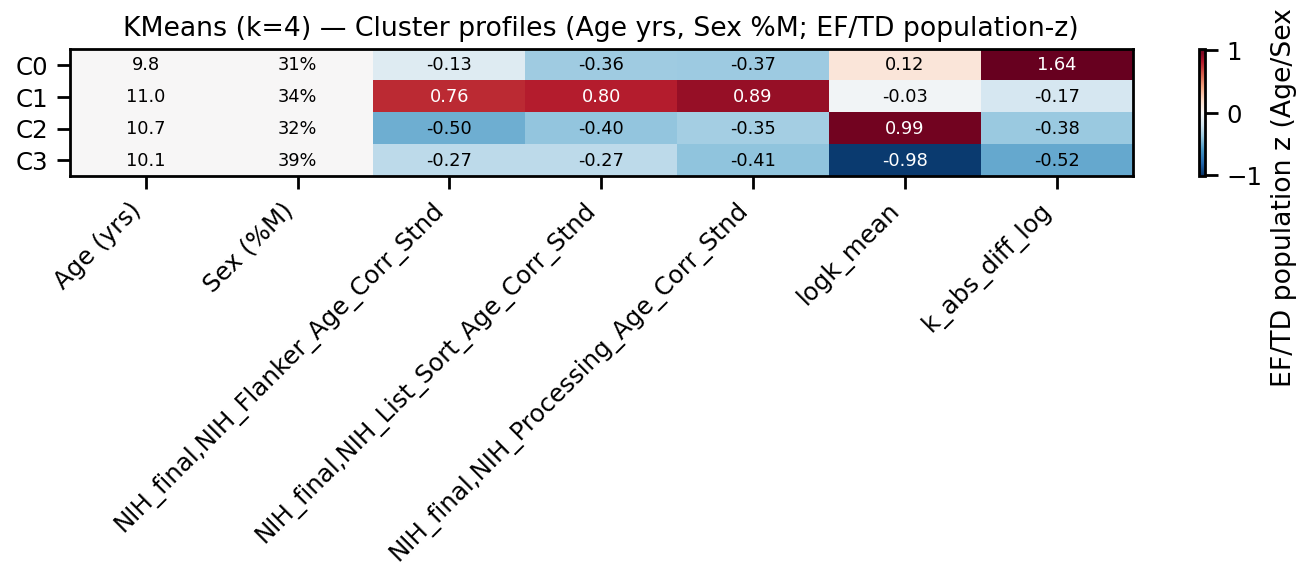

In [78]:
def kmeans_best(X_scaled, ks=(2, 3, 4, 5), n_init=20, random_state=0):
    best = None
    for k in ks:
        km = KMeans(n_clusters=k, n_init=n_init, random_state=random_state)
        lab = km.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, lab) if len(np.unique(lab)) > 1 else -np.inf
        cand = (sil, k, lab, km)
        if best is None or sil > best[0]:
            best = cand
    return best  # (sil, k, labels, model)

sil_km, k_km, lab_km, km_model = kmeans_best(Xp, ks=(2,3,4,5))
print(f"[KMeans] k={k_km} | silhouette={sil_km:.3f}")

plot_silhouette(f"KMeans (k={k_km})", lab_km, Xp)
plot_pca_scatter(f"KMeans (k={k_km})", lab_km, Z2)
profile(f"KMeans (k={k_km})", lab_km, z_cols=FEATURES)

## Gaussian Mixture (GMM)

[GMM] Best k=2 with silhouette=0.143
[GMM (k=2)] Silhouette: 0.143


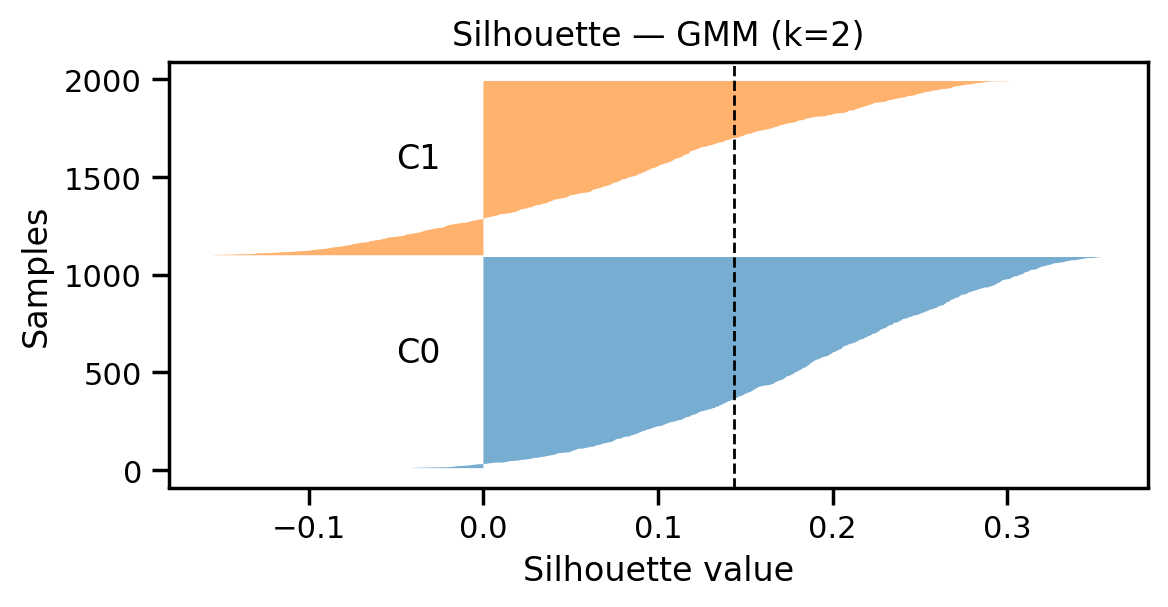

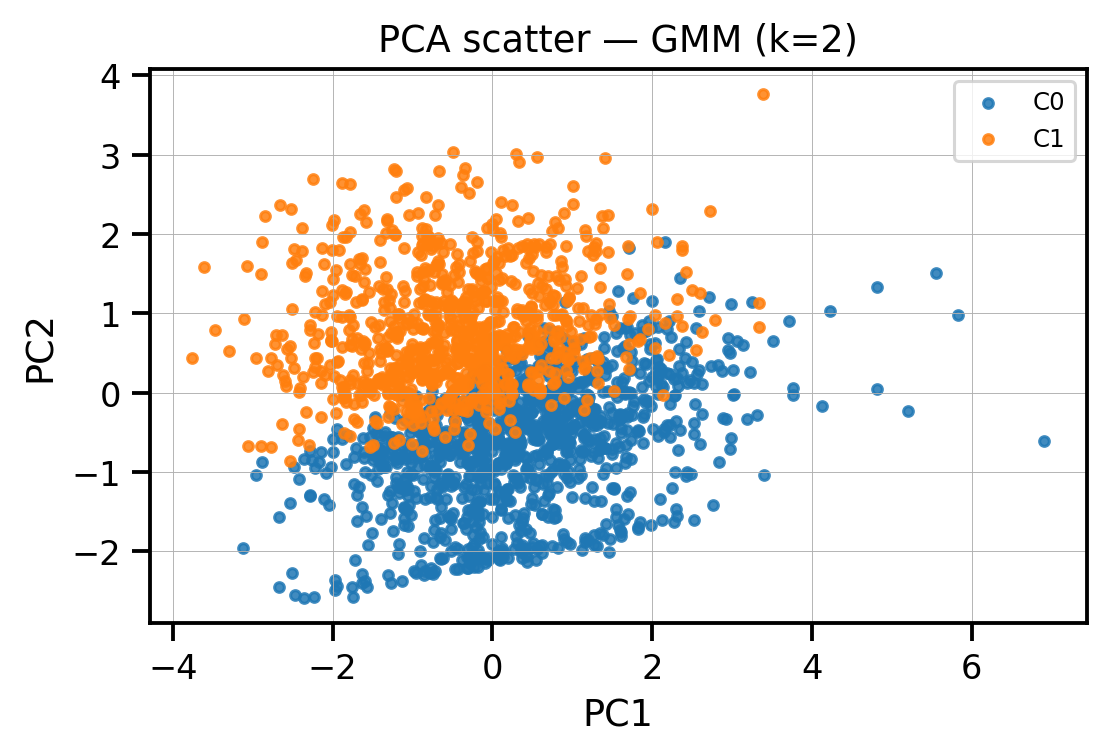

[GMM (k=2)] Cluster counts:
0    1082
1     893
Name: count, dtype: int64


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,10.600000,36.040000,0.080000,0.180000,0.140000,-0.450000,-0.570000
1,10.300000,31.950000,-0.100000,-0.220000,-0.170000,0.550000,0.680000


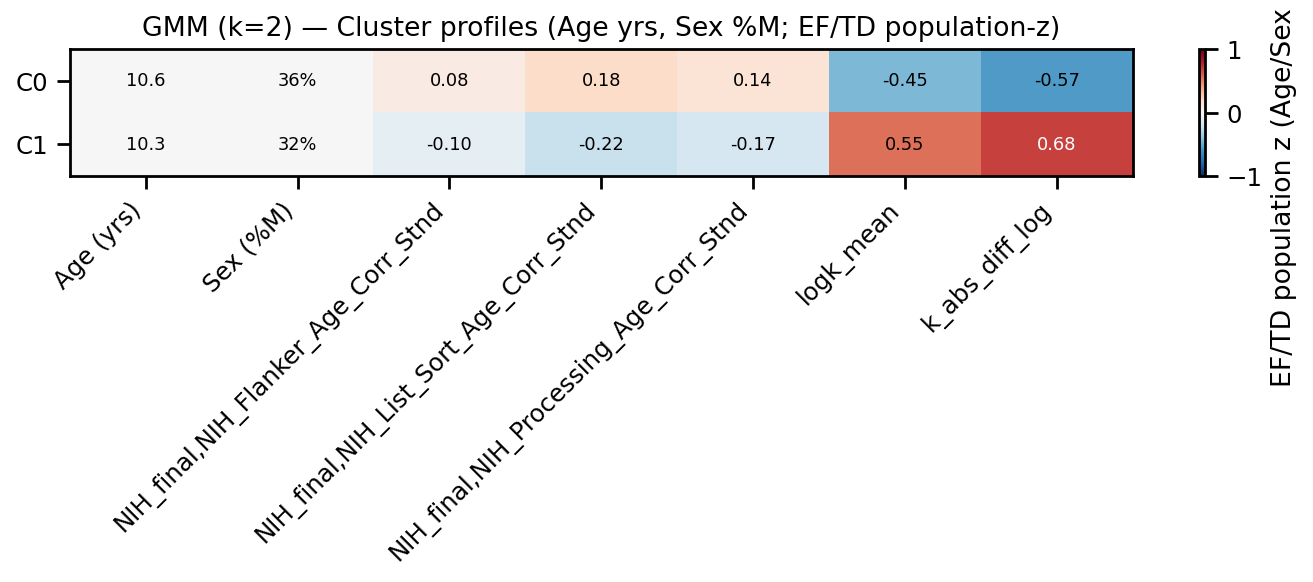

In [72]:
def run_gmm(X_scaled, ks=(2,3,4,5), random_state=0):
    best = None
    for k in ks:
        gmm = GaussianMixture(n_components=k, covariance_type="full", random_state=random_state)
        lab = gmm.fit_predict(X_scaled)
        if len(np.unique(lab)) < 2:
            score = -np.inf
        else:
            score = silhouette_score(X_scaled, lab)
        best = max(best, (score, k, lab), key=lambda t: t[0]) if best else (score, k, lab)
    return best  # (sil, k, labels)

sil_gmm, k_gmm, lab_gmm = run_gmm(Xp, ks=(2,3,4,5))
print(f"[GMM] Best k={k_gmm} with silhouette={sil_gmm:.3f}")

plot_silhouette(f"GMM (k={k_gmm})", lab_gmm, Xp)
plot_pca_scatter(f"GMM (k={k_gmm})", lab_gmm, Z2)
profile(f"GMM (k={k_gmm})", lab_gmm, z_cols=FEATURES)

## Agglomerative (Ward)

[Agglomerative] Best k=4 with silhouette=0.127
[Agglomerative (k=4)] Silhouette: 0.127


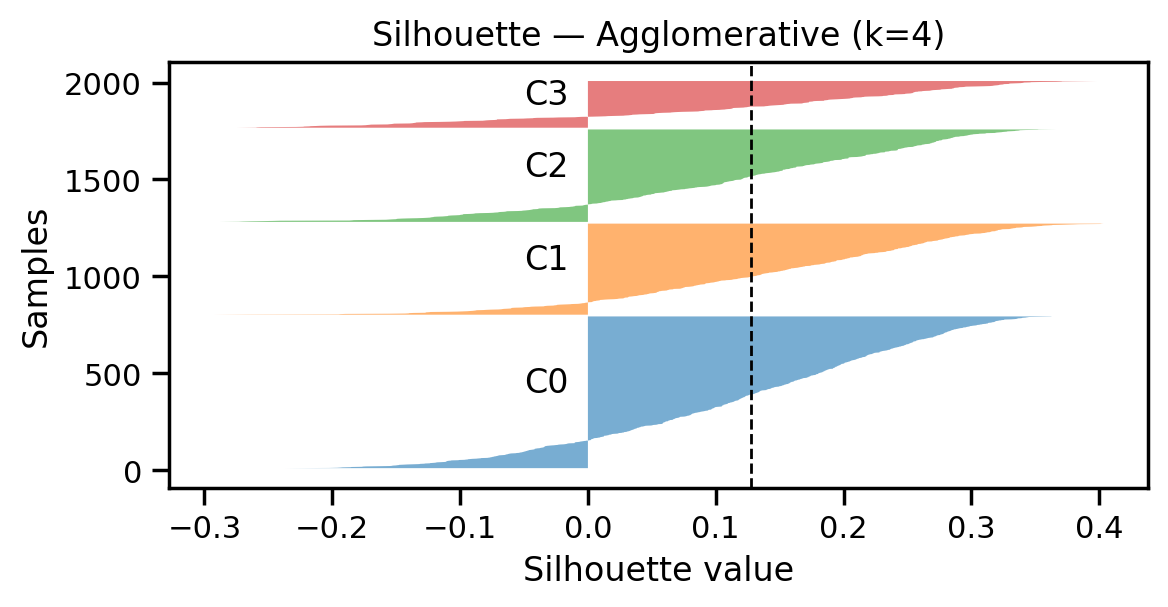

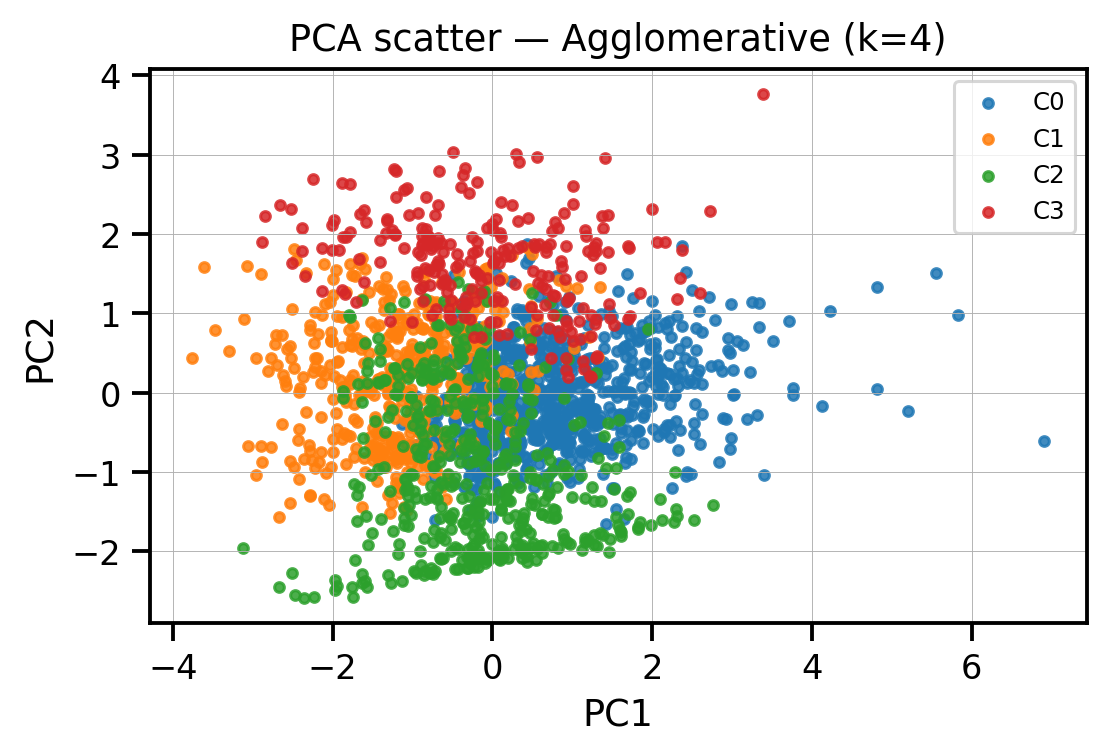

[Agglomerative (k=4)] Cluster counts:
0    784
2    478
1    471
3    242
Name: count, dtype: int64


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,11.260000,33.160000,0.260000,0.560000,0.610000,0.020000,-0.300000
1,10.520000,33.120000,-0.590000,-0.770000,-0.590000,0.780000,-0.190000
2,9.600000,36.820000,-0.030000,-0.210000,-0.420000,-1.090000,-0.190000
3,9.450000,34.440000,0.340000,0.130000,0.020000,0.570000,1.650000


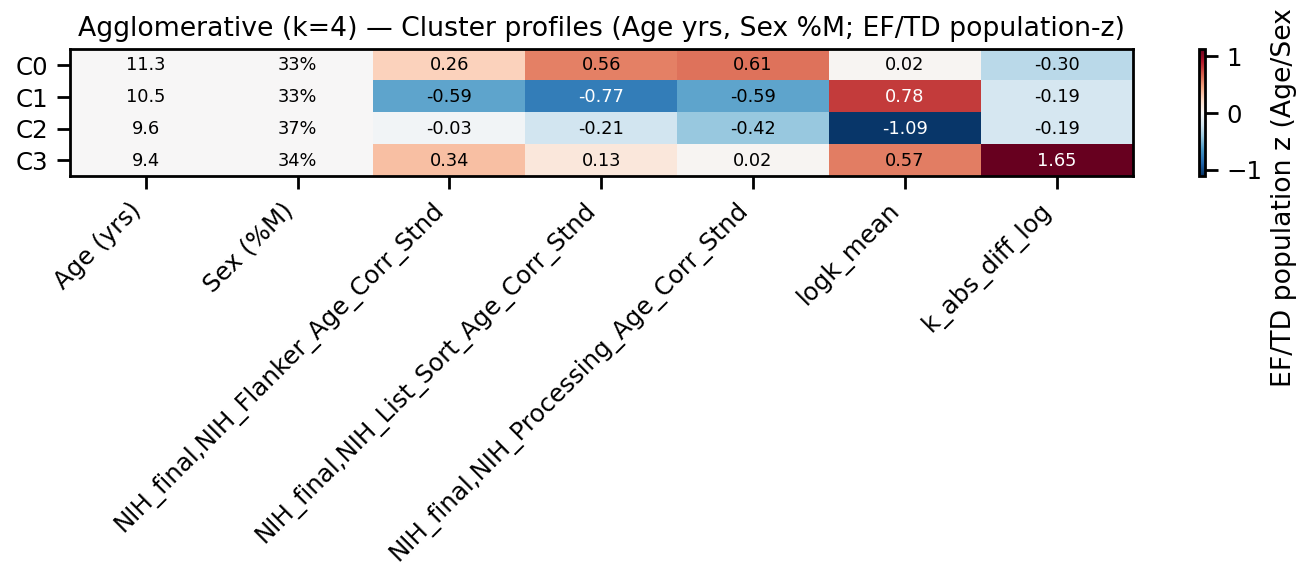

In [73]:
def run_agg(X_scaled, ks=(2,3,4,5)):
    best = None
    for k in ks:
        lab = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X_scaled)
        if len(np.unique(lab)) < 2:
            score = -np.inf
        else:
            score = silhouette_score(X_scaled, lab)
        best = max(best, (score, k, lab), key=lambda t: t[0]) if best else (score, k, lab)
    return best

sil_agg, k_agg, lab_agg = run_agg(Xp, ks=(2,3,4,5))
print(f"[Agglomerative] Best k={k_agg} with silhouette={sil_agg:.3f}")

plot_silhouette(f"Agglomerative (k={k_agg})", lab_agg, Xp)
plot_pca_scatter(f"Agglomerative (k={k_agg})", lab_agg, Z2)
profile(f"Agglomerative (k={k_agg})", lab_agg, z_cols=FEATURES)

## Spectral Clustering on a k-NN graph

[Spectral(KNN graph)] Best k=4, n_neighbors=20, silhouette=0.178
[Spectral KNN (k=4, nn=20)] Silhouette: 0.178


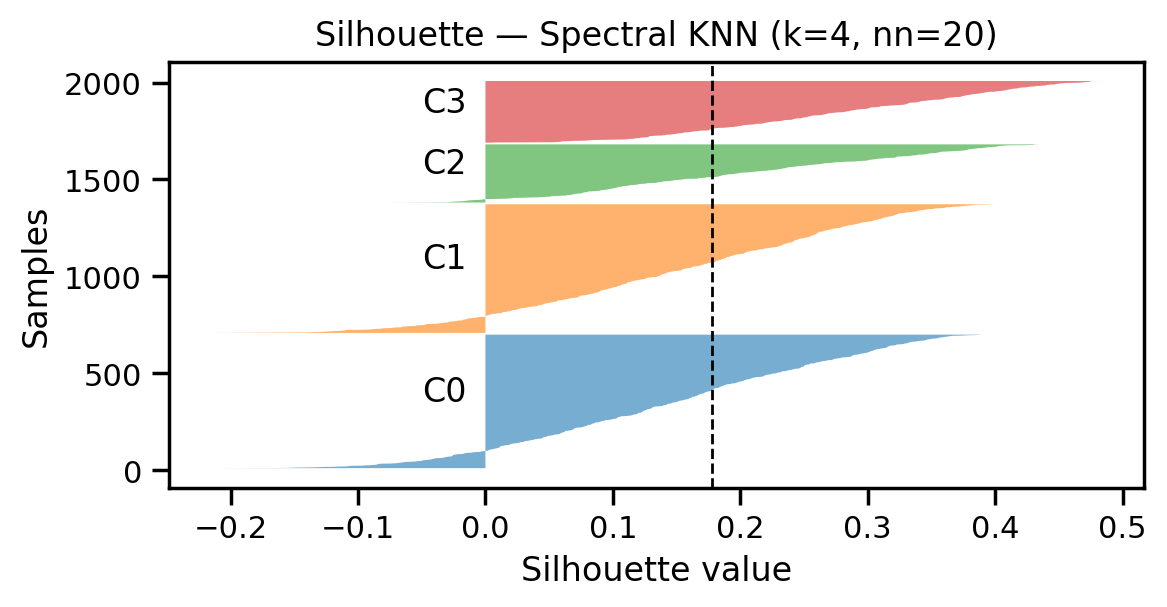

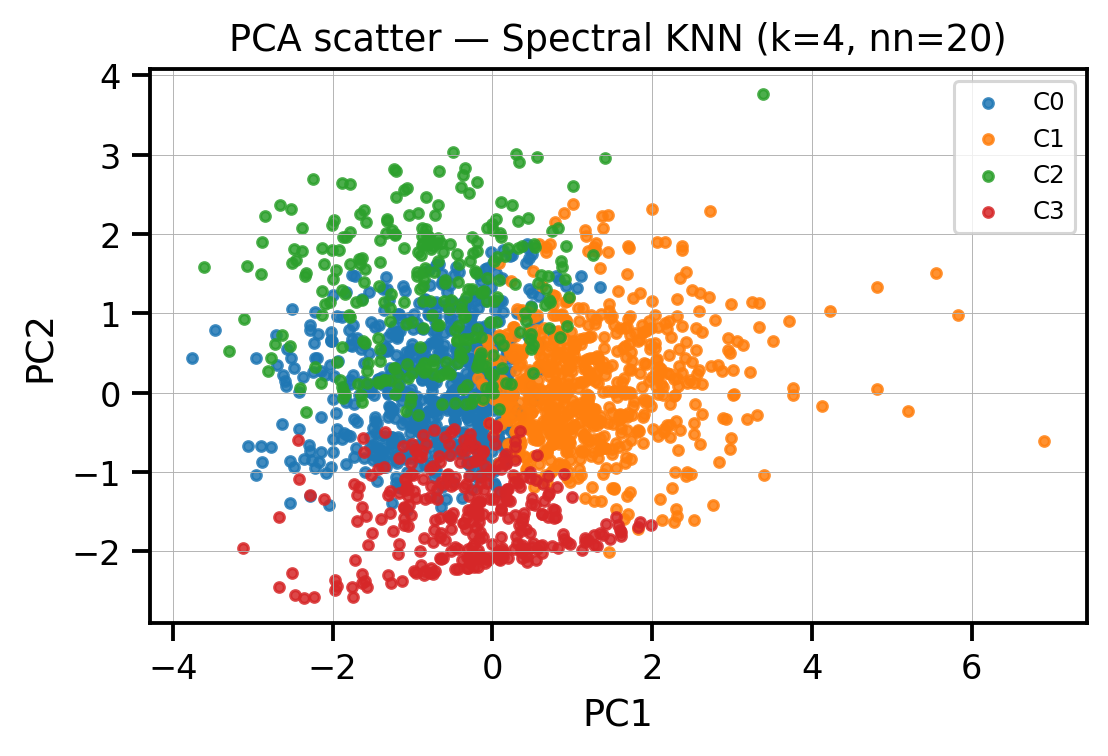

[Spectral KNN (k=4, nn=20)] Cluster counts:
0    690
1    665
3    319
2    301
Name: count, dtype: int64


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,10.700000,33.330000,-0.470000,-0.390000,-0.380000,0.690000,-0.330000
1,11.010000,34.440000,0.640000,0.740000,0.800000,-0.070000,-0.170000
2,9.650000,29.000000,-0.120000,-0.350000,-0.410000,0.080000,1.750000
3,9.580000,40.440000,-0.210000,-0.370000,-0.450000,-1.410000,-0.650000


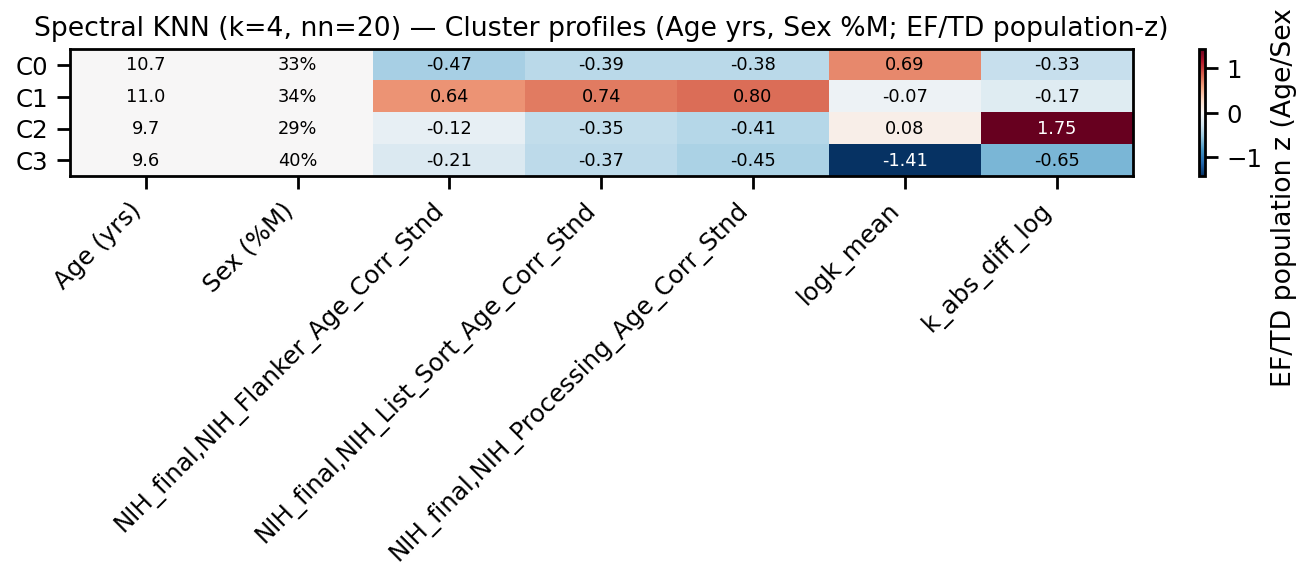

In [75]:
def run_spectral_knn(X_scaled, ks=(2,3,4,5), neighbors=(10,15,20), random_state=0):
    best = None
    for n_nb in neighbors:
        for k in ks:
            # Spectral can occasionally return a single cluster; catch/skip
            try:
                spec = SpectralClustering(
                    n_clusters=k,
                    affinity="nearest_neighbors",
                    n_neighbors=n_nb,
                    assign_labels="kmeans",
                    random_state=random_state,
                )
                lab = spec.fit_predict(X_scaled)
                if len(np.unique(lab)) < 2:
                    score = -np.inf
                else:
                    score = silhouette_score(X_scaled, lab)
                cand = (score, k, n_nb, lab)
                best = max(best, cand, key=lambda t: t[0]) if best else cand
            except Exception as e:
                print(f"[Spectral] Skipped k={k}, n_neighbors={n_nb}: {e}")
                continue
    return best  # (sil, k, n_neighbors, labels)

sil_sp, k_sp, nn_sp, lab_sp = run_spectral_knn(Xp, ks=(2,3,4,5), neighbors=(10,15,20))
print(f"[Spectral(KNN graph)] Best k={k_sp}, n_neighbors={nn_sp}, silhouette={sil_sp:.3f}")

plot_silhouette(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, Xp)
plot_pca_scatter(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, Z2)
profile(f"Spectral KNN (k={k_sp}, nn={nn_sp})", lab_sp, z_cols=FEATURES)

## Helper

In [67]:
def impute_original_units(X: pd.DataFrame) -> pd.DataFrame:
    """Median-impute numeric columns; returns DataFrame in original units."""
    imp = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    return X_imp

def plot_perm_importance(df, features, labels, title):
    lab = pd.Series(labels, index=df.index).dropna()
    X = df.loc[lab.index, features].apply(pd.to_numeric, errors="coerce")
    Xtr, Xte, ytr, yte = train_test_split(X, lab, test_size=0.3, random_state=0, stratify=lab)

    pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ]).fit(Xtr, ytr)

    pi = permutation_importance(pipe, Xte, yte, n_repeats=20, random_state=0)
    imp = pd.Series(pi.importances_mean, index=features).sort_values()

    acc = pipe.score(Xte, yte)
    plt.figure(figsize=(6.2, 3.6), dpi=200)
    imp.plot.barh()
    plt.title(f"{title} — Permutation importance (acc={acc:.2f})")
    plt.xlabel("Importance (mean Δ accuracy)")
    plt.tight_layout(); plt.show()

# Method Selection

## 0) Gather clustering labels

In [83]:

labels_dict = {}
def add_labels(name, arr, treat_noise_as_invalid=False):
    if arr is None: return
    arr = np.asarray(arr)
    if arr.ndim != 1 or len(arr) != len(Xp): return
    valid = np.ones(len(arr), dtype=bool)
    if treat_noise_as_invalid:
        valid &= (arr >= 0)
    labels_dict[name] = {"labels": arr, "valid": valid}

add_labels("KMeans",         globals().get("lab_km"))
add_labels("GMM",            globals().get("lab_gmm"))
add_labels("Agglomerative",  globals().get("lab_agg"))
add_labels("HDBSCAN",        globals().get("lab_hdb"), treat_noise_as_invalid=True)
add_labels("Spectral",       globals().get("lab_sp"))

if not labels_dict:
    raise RuntimeError("No clustering labels found. Define lab_km/lab_gmm/lab_agg/lab_hdb/lab_sp first.")


## 1) Per-method silhouette (on the subset each method considers valid)

In [84]:

def safe_silhouette(X, y, valid_mask):
    yv = y[valid_mask]
    if len(np.unique(yv)) < 2: 
        return np.nan
    return silhouette_score(X[valid_mask], yv)

for name, d in labels_dict.items():
    d["silhouette"] = safe_silhouette(Xp, d["labels"], d["valid"])
    # effective number of clusters (excluding noise for HDBSCAN)
    yv = d["labels"][d["valid"]]
    d["n_clusters"] = len(np.unique(yv))

## 2) Pairwise Adjusted Rand Index 
- "Agreement" between this method’s labels and the labels from the other methods, then averaged.
- Higher ⇒ this partition is more consistent with the others.

In [85]:

meths = list(labels_dict.keys())
ari_matrix = pd.DataFrame(np.nan, index=meths, columns=meths)
for a in meths:
    for b in meths:
        va = labels_dict[a]["valid"]; la = labels_dict[a]["labels"]
        vb = labels_dict[b]["valid"]; lb = labels_dict[b]["labels"]
        m = va & vb
        if m.sum() >= 2 and len(np.unique(la[m]))>1 and len(np.unique(lb[m]))>1:
            ari_matrix.loc[a,b] = adjusted_rand_score(la[m], lb[m])

mean_ari = ari_matrix.replace(1.0, np.nan).mean(axis=1)  # exclude perfect self-ARI


## 3) Interpretability & demographic dominance
- η² for EF/TD (higher median = clearer separation on mechanism)
    - Using the median avoids one feature with an extreme η² dominating the summary
    - reflects the “typical” separation on EF/TD.
- η² for Age (want smaller than EF/TD median)
- Cramér’s V for Sex (want small)

In [118]:

def eta_squared_num(y, x):
    # y: numeric vector; x: cluster labels
    df_ = pd.DataFrame({"y": y, "x": x}).dropna()
    if df_.empty or df_["x"].nunique()<2: return np.nan
    grand = df_["y"].mean()
    ss_tot = ((df_["y"] - grand)**2).sum()
    ss_between = sum([(g["y"].count() * (g["y"].mean() - grand)**2) for _, g in df_.groupby("x")])
    return float(ss_between/ss_tot) if ss_tot>0 else np.nan

def _cramers_v_bias_corrected(ct: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    if n == 0:
        return np.nan
    r, k = ct.shape
    phi2 = chi2 / n
    # Bergsma (2013) small-sample correction
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

def cramers_v_from_series(labels, sex_series) -> float:
    """
    Calculate Cramér's V between cluster labels and sex (FIXED VERSION).
    
    Handles numeric Sex values (0, 1, 0.0, 1.0) properly.
    """
    # Align by position
    lab = pd.Series(labels).reset_index(drop=True)
    s = pd.Series(sex_series).reset_index(drop=True)
    
    # Remove missing values first
    valid = lab.notna() & s.notna()
    lab = lab[valid]
    s = s[valid]
    
    if len(lab) < 10:  # Minimum sample size
        return np.nan
    
    # FIX: Convert to numeric first, THEN map
    s = pd.to_numeric(s, errors='coerce')
    sex_map = {0: "female", 1: "male", 0.0: "female", 1.0: "male"}
    s = s.map(sex_map)
    
    # Fallback for string formats
    if s.isna().any():
        s_orig = pd.Series(sex_series).reset_index(drop=True)[valid]
        s_fallback = (s_orig.astype(str).str.strip().str.lower()
                      .replace({"m": "male", "f": "female", 
                               "male": "male", "female": "female",
                               "0": "female", "1": "male",
                               "0.0": "female", "1.0": "male"}))
        s = s.fillna(s_fallback)
    
    # Final validity check
    ok = s.isin(["male", "female"]) & lab.notna()
    lab = lab[ok]
    s = s[ok]
    
    if lab.nunique() < 2 or s.nunique() < 2 or len(lab) < 10:
        return np.nan
    
    ct = pd.crosstab(lab, s)
    return float(_cramers_v_bias_corrected(ct))



## 4) Summary

In [119]:
summary_rows = []
for name, d in labels_dict.items():
    m = d["valid"]                 # boolean mask for this method
    y = d["labels"][m]             # labels for those rows

    # η² across EF+TD features (median)
    ef_td_eta2 = [eta_squared_num(df.loc[m, col], y) for col in FEATURES]
    median_eta2 = float(np.nanmedian(ef_td_eta2))

    eta2_age = eta_squared_num(df.loc[m, "Age"], y) if "Age" in df.columns else np.nan
    cv_sex   = cramers_v_from_series(y, prof.loc[m, "Sex"]) if "Sex" in prof.columns else np.nan

    summary_rows.append({
        "method": name,
        "n_clusters": d["n_clusters"],
        "n_points_used": int(m.sum()),
        "silhouette": d["silhouette"],
        "mean_ARI": mean_ari.get(name, np.nan),
        "median_eta2_EF_TD": median_eta2,
        "eta2_age": eta2_age,
        "cramerV_sex": cv_sex,
    })

summary = pd.DataFrame(summary_rows).sort_values(
    ["silhouette","mean_ARI"], ascending=False
)

In [120]:
display(summary.style.format({
    "silhouette": "{:.3f}",
    "mean_ARI": "{:.3f}",
    "median_eta2_EF_TD": "{:.3f}",
    "eta2_age": "{:.3f}",
    "cramerV_sex": "{:.3f}",
}))

,method,n_clusters,n_points_used,silhouette,mean_ARI,median_eta2_EF_TD,eta2_age,cramerV_sex
3,HDBSCAN,2,339,0.368,0.145,0.080,0.037,0.000
0,KMeans,4,1975,0.184,0.289,0.339,0.018,0.044
4,Spectral,4,1975,0.178,0.363,0.324,0.029,0.057
1,GMM,2,1975,0.143,0.100,0.041,0.002,0.037
2,Agglomerative,4,1975,0.127,0.306,0.278,0.047,0.000


- `n_clusters`: how many clusters that method produced.
- `n_points_used`: how many participants were actually clustered.
    - Only HDBSCAN can mark points as noise (unassigned), so its count (339) is much smaller than 1,975
- `silhouette`: cohesion/separation of the clusters (−1 to 1; higher is better).
    - HDBSCAN looks best here, but it’s on a much smaller, cleaner subset; silhouettes aren’t strictly comparable when the sample sizes differ that much.
- `mean_ARI`: “agreement” with other partitions.
    - Spectral and Agglomerative show the best cross-method agreement; KMeans is decent; GMM and HDBSCAN agree less with the rest (HDBSCAN partly because it drops many points).
- `median_eta2_EF_TD`: typical effect size (η²) for EF/TD features when comparing clusters.
    - KMeans and Spectral show the strongest EF/TD separation.
- `eta2_age`: effect size for Age differences across clusters

## 5) Choose winner:
- silhouette within 90% of the best
- not dominated by demographics:
    - EF/TD median  $η² >= 2×$ max(eta2_age, cramerV_sex^2 approx effect)
    - Sex association modest (Cramér’s V <= 0.3)

In [121]:
best_sil = summary["silhouette"].max(skipna=True)
def dominance_pass(row):
    dem = np.nanmax([row["eta2_age"], (row["cramerV_sex"] or 0)**2])
    return (row["median_eta2_EF_TD"] >= 2.0 * dem) and (row["cramerV_sex"] <= 0.30)

cands = summary[
    (summary["silhouette"] >= 0.90*best_sil) &
    summary.apply(dominance_pass, axis=1)
].copy()

if cands.empty:
    # fall back: just take top silhouette that isn't trivially demographic
    cands = summary.head(1)

chosen = cands.sort_values(["mean_ARI","median_eta2_EF_TD","silhouette"],
                           ascending=[False, False, False]).head(1)
display(chosen)

,method,n_clusters,n_points_used,silhouette,mean_ARI,median_eta2_EF_TD,eta2_age,cramerV_sex
3,HDBSCAN,2,339,0.367953,0.145011,0.080147,0.037081,0.0


In [122]:
chosen_name = chosen.iloc[0]["method"]
chosen_mask = labels_dict[chosen_name]["valid"]
chosen_labels = labels_dict[chosen_name]["labels"]

print(f"\nChosen partition: {chosen_name} | k={labels_dict[chosen_name]['n_clusters']} | "
      f"sil={labels_dict[chosen_name]['silhouette']:.3f}")


Chosen partition: HDBSCAN | k=2 | sil=0.368


# Improved Method Selection

## Cluster Evaluator

In [134]:
def eta_squared_num(y: pd.Series, labels: np.ndarray) -> float:
    df_ = pd.DataFrame({"y": pd.to_numeric(y, errors="coerce"), "lab": labels}).dropna()
    if df_["lab"].nunique() < 2:
        return np.nan
    grand = df_["y"].mean()
    ss_tot = ((df_["y"] - grand)**2).sum()
    if ss_tot == 0:
        return np.nan
    ss_between = sum(len(g)*(g["y"].mean() - grand)**2 for _, g in df_.groupby("lab"))
    return float(ss_between / ss_tot)

def _cramers_v_bias_corrected(ct: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(ct, correction=False)
    n = ct.to_numpy().sum()
    if n == 0: return np.nan
    r, k = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    return np.sqrt(phi2corr / denom) if denom > 0 else np.nan

def cramers_v_from_series(labels, sex_series) -> float:
    """
    Calculate Cramér's V between cluster labels and sex (FIXED VERSION).
    
    Handles numeric Sex values (0, 1, 0.0, 1.0) properly.
    """
    # Align by position
    lab = pd.Series(labels).reset_index(drop=True)
    s = pd.Series(sex_series).reset_index(drop=True)
    
    # Remove missing values first
    valid = lab.notna() & s.notna()
    lab = lab[valid]
    s = s[valid]
    
    if len(lab) < 10:  # Minimum sample size
        return np.nan
    
    # FIX: Convert to numeric first, THEN map
    s = pd.to_numeric(s, errors='coerce')
    sex_map = {0: "female", 1: "male", 0.0: "female", 1.0: "male"}
    s = s.map(sex_map)
    
    # Fallback for string formats
    if s.isna().any():
        s_orig = pd.Series(sex_series).reset_index(drop=True)[valid]
        s_fallback = (s_orig.astype(str).str.strip().str.lower()
                      .replace({"m": "male", "f": "female", 
                               "male": "male", "female": "female",
                               "0": "female", "1": "male",
                               "0.0": "female", "1.0": "male"}))
        s = s.fillna(s_fallback)
    
    # Final validity check
    ok = s.isin(["male", "female"]) & lab.notna()
    lab = lab[ok]
    s = s[ok]
    
    if lab.nunique() < 2 or s.nunique() < 2 or len(lab) < 10:
        return np.nan
    
    ct = pd.crosstab(lab, s)
    return float(_cramers_v_bias_corrected(ct))

def sil_with_coverage(X, labels):
    if len(np.unique(labels)) < 2:
        return np.nan, 0.0, np.nan
    sil = silhouette_score(X, labels)
    cov = len(labels) / X.shape[0]
    return sil, cov, sil*cov

In [135]:
class ClusteringEvaluator:
    def __init__(self, X_scaled: np.ndarray, df_original: pd.DataFrame, feature_cols: List[str]):
        self.X = X_scaled
        self.df = df_original
        self.feature_cols = feature_cols
        self.results: Dict[str, dict] = {}

    def evaluate(self, name: str, labels: np.ndarray, valid_mask: np.ndarray,
                 fit_predict_fn: Callable[[np.ndarray], np.ndarray]) -> dict:
        # keep only valid (non-noise) rows for metrics
        m = valid_mask.astype(bool)
        Xc = self.X[m]
        dfc = self.df.iloc[m]
        labs = np.asarray(labels)[m]

        n_clusters = len(np.unique(labs))
        sil, cov, sil_cov = sil_with_coverage(Xc, labs)

        res = {
            "method": name,
            "n_clusters": n_clusters,
            "n_points": int(m.sum()),
            "noise_pct": 100.0*(~m).mean(),
            "silhouette": sil,
            "coverage": cov,
            "silhouette_x_coverage": sil_cov,
            "stability": self._bootstrap_stability(m, labs, fit_predict_fn),
            "feature_separation_median_eta2": self._median_eta2(dfc, labs),
            "eta2_age": eta_squared_num(dfc.get("Age"), labs) if "Age" in dfc else np.nan,
            "cramersV_sex": cramers_v_from_series(labs, dfc.get("Sex")) if "Sex" in dfc else np.nan,
            "cluster_balance": self._balance(labs),
            "cluster_homogeneity": self._homogeneity(dfc, labs)
        }
        self.results[name] = res
        return res

    def _bootstrap_stability(self, mask: np.ndarray, labs_ref: np.ndarray,
                             fit_predict_fn: Callable[[np.ndarray], np.ndarray],
                             n_boot: int = 30, frac: float = 0.8) -> float:
        # indices in the valid set
        idx_valid = np.where(mask)[0]
        if len(np.unique(labs_ref)) < 2 or len(idx_valid) < 30:
            return np.nan
        aris = []
        for _ in range(n_boot):
            samp = np.random.choice(idx_valid, size=int(frac*len(idx_valid)), replace=False)
            # re-fit on the **sampled rows** and get labels **for those rows**
            labs_boot = fit_predict_fn(samp)
            if labs_boot is None:     # e.g., method can’t be re-fit
                return np.nan
            if len(np.unique(labs_boot)) < 2:  # degenerate
                continue
            # compare to reference labels on the same sampled indices
            aris.append(adjusted_rand_score(labs_ref[np.isin(np.where(mask)[0], samp)], labs_boot))
        return float(np.mean(aris)) if aris else np.nan

    def _median_eta2(self, dfc: pd.DataFrame, labs: np.ndarray) -> float:
        vals = []
        for c in self.feature_cols:
            if c in dfc:
                vals.append(eta_squared_num(dfc[c], labs))
        vals = [v for v in vals if pd.notna(v)]
        return float(np.median(vals)) if vals else np.nan

    @staticmethod
    def _balance(labels: np.ndarray) -> float:
        counts = pd.Series(labels).value_counts()
        p = counts / counts.sum()
        H = -(p*np.log2(p)).sum()
        return float(H / np.log2(len(counts))) if len(counts) > 1 else np.nan

    def _homogeneity(self, dfc: pd.DataFrame, labs: np.ndarray) -> float:
        ratios = []
        for c in self.feature_cols:
            if c in dfc:
                sd_all = dfc[c].std()
                if sd_all > 0:
                    ratios.append(dfc.groupby(labs)[c].std().mean() / sd_all)
        return float(1 - np.mean(ratios)) if ratios else np.nan

    def compare(self, weights=None) -> pd.DataFrame:
        if weights is None:
            weights = {"silhouette_x_coverage": .2, "stability": .3,
                       "feature_separation_median_eta2": .3,
                       "low_demo": .15, "interpret": .05}
        rows = []
        for name, r in self.results.items():
            demo = max(r.get("eta2_age", 0), (r.get("cramersV_sex", 0) ** 2))
            score = (
                weights["silhouette_x_coverage"] * max(0, (r["silhouette_x_coverage"]+1)/2) +
                weights["stability"]               * (r["stability"] if pd.notna(r["stability"]) else 0) +
                weights["feature_separation_median_eta2"] * (r["feature_separation_median_eta2"] or 0) +
                weights["low_demo"]                * max(0, 1 - demo/0.20) +
                weights["interpret"]               * np.nanmean([r["cluster_balance"], r["cluster_homogeneity"]])
            )
            rows.append({**r, "composite_score": float(score)})
        return pd.DataFrame(rows).sort_values("composite_score", ascending=False)

In [136]:
N = len(df)
labels_dict = {}

# --- KMeans (k=4) ---
km = KMeans(n_clusters=4, n_init=20, random_state=0).fit(Xp)
lab_km = km.labels_
labels_dict["KMeans"] = {
    "labels": lab_km,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: KMeans(n_clusters=4, n_init=10, random_state=0).fit(Xp[idx]).labels_
}

# --- GMM (k=2 or 4) ---
gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=0).fit(Xp)
lab_gmm = gmm.predict(Xp)
labels_dict["GMM"] = {
    "labels": lab_gmm,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: GaussianMixture(n_components=2, covariance_type="full", random_state=0).fit(Xp[idx]).predict(Xp[idx])
}

# --- Agglomerative (k=4) ---
agg = AgglomerativeClustering(n_clusters=4, linkage="ward")
lab_agg = agg.fit_predict(Xp)
labels_dict["Agglomerative"] = {
    "labels": lab_agg,
    "valid": np.ones(N, dtype=bool),
    "fit_predict": lambda idx: AgglomerativeClustering(n_clusters=4, linkage="ward").fit_predict(Xp[idx])
}

# --- HDBSCAN ---
hdb = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10)
lab_hdb = hdb.fit_predict(Xp)
valid_hdb = lab_hdb >= 0
labels_dict["HDBSCAN"] = {
    "labels": lab_hdb,
    "valid": valid_hdb,
    "fit_predict": lambda idx: hdbscan.HDBSCAN(min_cluster_size=40, min_samples=10).fit_predict(Xp[idx])
}

# --- Spectral (nearest-neighbors graph) ---
spec_knn = SpectralClustering(
    n_clusters=4,
    affinity="nearest_neighbors",   # KNN graph scales better than full RBF
    n_neighbors=20,                 # try 10–30; tune if needed
    assign_labels="kmeans",
    random_state=0
)
lab_spec = spec_knn.fit_predict(Xp)

labels_dict["Spectral-KNN"] = {
    "labels": lab_spec,
    "valid": np.ones(N, dtype=bool),   \
    "fit_predict": lambda idx: SpectralClustering(
        n_clusters=4,
        affinity="nearest_neighbors",
        n_neighbors=20,
        assign_labels="kmeans",
        random_state=0
    ).fit_predict(Xp[idx])
}

In [137]:
evaluator = ClusteringEvaluator(Xp, df[FEATURES + ["Age","Sex"]], FEATURES)

results = []
for name, pack in labels_dict.items():
    res = evaluator.evaluate(
        name=name,
        labels=pack["labels"],
        valid_mask=pack["valid"],
        fit_predict_fn=pack["fit_predict"]
    )
    results.append(res)

comp = evaluator.compare()
display(comp.style.format({
    "silhouette": "{:.3f}", "coverage": "{:.2f}",
    "silhouette_x_coverage": "{:.3f}", "stability": "{:.3f}",
    "feature_separation_median_eta2": "{:.3f}",
    "eta2_age": "{:.3f}", "cramersV_sex": "{:.3f}",
    "cluster_balance": "{:.3f}", "cluster_homogeneity": "{:.3f}",
    "composite_score": "{:.3f}"
}))

,method,n_clusters,n_points,noise_pct,silhouette,coverage,silhouette_x_coverage,stability,feature_separation_median_eta2,eta2_age,cramersV_sex,cluster_balance,cluster_homogeneity,composite_score
0,KMeans,4,1975,0.000000,0.184,1.00,0.184,-0.000,0.339,0.018,0.044,0.986,0.230,0.387
4,Spectral-KNN,4,1975,0.000000,0.178,1.00,0.178,0.000,0.324,0.029,0.057,0.949,0.235,0.373
2,Agglomerative,4,1975,0.000000,0.127,1.00,0.127,-0.000,0.278,0.047,0.000,0.944,0.168,0.338
3,HDBSCAN,2,338,82.886076,0.368,1.00,0.368,0.034,0.117,0.034,0.000,0.605,0.246,0.328
1,GMM,2,1975,0.000000,0.143,1.00,0.143,-0.000,0.041,0.002,0.037,0.993,0.088,0.302


## Interpretation

| Column | What it measures | How it’s computed (short) | How to read it |
|---|---|---|---|
| **coverage** | % of rows that received a cluster label | `n_labeled / n_total`. Needed because some methods (e.g., HDBSCAN) mark “noise”. | Closer to **1.0** is better (more of your dataset is clustered). |
| **silhouette_x_coverage** | Compactness/separation of clusters **adjusted for coverage** | Silhouette score (∈[-1,1]) computed **only on labeled points** and then multiplied by `coverage` so a tiny, clean subset doesn’t look artificially great. | Larger is better. As rough guidance: ~0.00=weak, ~0.10–0.25=ok in messy human data, ≥0.30=good. |
| **stability** | How reproducible labels are under resampling | Bootstrap-based adjusted Rand index (ARI) on overlapping resamples (0–1). | Larger is better. ~0 means labels are unstable to small changes; ≥0.3 begins to look usable; ≥0.5 is solid. |
| **feature_separation_median_eta2** | Do clusters actually differ on the features you clustered on (EF/TD)? | For each EF/TD feature, η² from one-way ANOVA across clusters; then take the **median** across features (0–1). | Larger is better. Rule of thumb for η²: ~0.01=small, ~0.06=medium, ~0.14+=large. Median is robust to one odd feature dominating. |
| **eta2_age** | How much **Age** differences alone explain the clustering | η² for Age vs cluster labels (0–1). | **Lower** is better (you don’t want age to drive the solution). Values near 0.00–0.05 suggest age isn’t dominating. |
| **cramersV_sex** | Association between **Sex** and cluster labels | Bias-corrected Cramér’s V from the cluster×sex contingency table (0–1). | **Lower** is better. Heuristics: ~0.10=small, ~0.30=medium, ~0.50=large. |
| **cluster_balance** | Whether cluster sizes are balanced | Normalized entropy of cluster size proportions (0–1). | **Higher** is better; ~1 means sizes are even. Very low values mean a dominant cluster + tiny satellites. |
| **cluster_homogeneity** | Within-cluster tightness relative to overall spread | 1 − (mean within-cluster SD / overall SD), averaged across features (0–1). | **Higher** is better (tighter clusters). |
| **composite_score** | One number to compare methods | Weighted blend of the above (defaults: silhouette 0.20, stability 0.30, feature separation 0.30, **low** demographic confound 0.15, interpretability 0.05). | **Higher** is better. Use it to rank methods, then sanity-check profiles. |

---

## How to pick
1. **Scan `composite_score`**: take the top 1–2 candidates.
2. **Check the drivers**: you want **moderate+ `silhouette_x_coverage`** and **high `feature_separation_median_eta2`**.
3. **Guardrails**: ensure **`eta2_age` and `cramersV_sex` are small** (demographics not driving).
4. **Reliability**: prefer **higher `stability`** if two methods are close.
5. **Practicality**: avoid solutions with very poor **`cluster_balance`**.

---

- All rows show **coverage=1.00**, so every method labeled all rows (no noise left out).
- `silhouette_x_coverage` ranges ~0.14–0.37 → modest separation; the best row has the cleanest geometry.
- `feature_separation_median_eta2` spans ~0.041–0.339 → only the top one or two rows show **meaningful EF/TD separation**.
- `eta2_age` is ~0.002–0.047 and `cramersV_sex` ~0.000–0.057 → **demographics are not dominating** (good).
- `cluster_balance` is ≥0.60 (most ≈0.95+) → sizes are fairly even.
- The **row with the highest `composite_score`** is your current best overall trade-off; profile that one first and sanity-check the EF/TD heatmap.

Chosen method: KMeans


,Age (yrs),Sex (%M),"NIH_final,NIH_Flanker_Age_Corr_Stnd","NIH_final,NIH_List_Sort_Age_Corr_Stnd","NIH_final,NIH_Processing_Age_Corr_Stnd",logk_mean,k_abs_diff_log
0,9.750000,31.140000,-0.130000,-0.360000,-0.370000,0.120000,1.640000
1,10.970000,33.500000,0.760000,0.800000,0.890000,-0.030000,-0.170000
2,10.720000,32.360000,-0.500000,-0.400000,-0.350000,0.990000,-0.380000
3,10.110000,38.590000,-0.270000,-0.270000,-0.410000,-0.980000,-0.520000


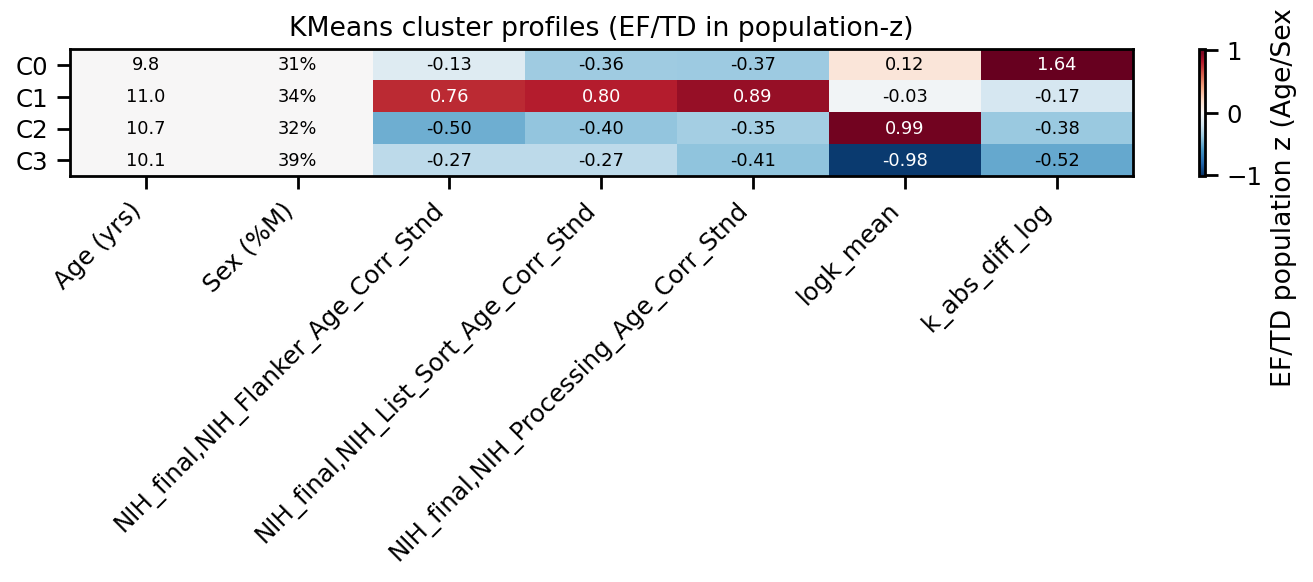

In [138]:
best_row = comp.iloc[0]
best_name = best_row["method"]
print("Chosen method:", best_name)

labs = labels_dict[best_name]["labels"]
valid = labels_dict[best_name]["valid"]

profile_table_and_heatmap_mixed(
    df_original=pd.concat([df[FEATURES], df[["Age","Sex"]]], axis=1),
    labels=labs,
    z_cols=FEATURES,  # EF/TD columns are z-colored; Age/Sex printed only
    title=f"{best_name} cluster profiles (EF/TD in population-z)"
)